### Transfer learning with TF Part 2: Fine-tuning

In [1]:
!nvidia-smi

Thu Jul  6 11:37:51 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-07-06 11:37:51--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-07-06 11:37:52 (78.0 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

In [4]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data('10_food_classes_10_percent.zip')

--2023-07-06 11:37:55--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.1.128, 108.177.121.128, 142.250.103.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.1.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   189MB/s    in 0.9s    

2023-07-06 11:37:56 (189 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [5]:
walk_through_dir('10_food_classes_10_percent')

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent

In [6]:
train_dir = '10_food_classes_10_percent/train'
test_dir = '10_food_classes_10_percent/test'

In [7]:
import tensorflow as tf

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode='categorical',
                                                                            batch_size=BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                image_size=IMG_SIZE,
                                                                label_mode='categorical',
                                                                batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [8]:
train_data_10_percent

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [9]:
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

# Model 0: Building a transfer learning model using the Keras Functional Api


In [10]:
# 1.  Create the base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the model
base_model.trainable = False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name='input_layer')

# Optional : if using a REsNet50v2 you will need to normalize inputs
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1/255.)(inputs) # efficient net has rescale build in

# 5. Pass the inputs to the base model
x = base_model(inputs)
print(f"Shape after passing inputs throughh base model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important information i.e reduce the number of pixel and saves computation)
x = tf.keras.layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)
print(f"Shape after global average pooling2d: {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation='softmax', name='output_layer')(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

16705208/16705208 [==============================] - 0s 0us/step
Shape after passing inputs throughh base model: (None, 7, 7, 1280)
Shape after global average pooling2d: (None, 1280)


In [11]:
# 10. Fit the model
history_10_percent = model_0.fit(train_data_10_percent,
                epochs=5,
                steps_per_epoch=len(train_data_10_percent),
                validation_data=test_data,
                validation_steps=int(0.25 * len(test_data)),
                callbacks=[create_tensorboard_callback('transfer_learning', '10_percent')])

Saving TensorBoard log files to: transfer_learning/10_percent/20230706-113811


Epoch 1/5
24/24 [==============================] - 27s 354ms/step - loss: 2.0063 - accuracy: 0.3493 - val_loss: 1.3654 - val_accuracy: 0.7204
Epoch 2/5
24/24 [==============================] - 4s 145ms/step - loss: 1.1591 - accuracy: 0.7573 - val_loss: 0.8598 - val_accuracy: 0.8372
Epoch 3/5
24/24 [==============================] - 5s 207ms/step - loss: 0.8244 - accuracy: 0.8173 - val_loss: 0.6658 - val_accuracy: 0.8651
Epoch 4/5
24/24 [==============================] - 5s 178ms/step - loss: 0.6544 - accuracy: 0.8493 - val_loss: 0.5842 - val_accuracy: 0.8865
Epoch 5/5
24/24 [==============================] - 5s 177ms/step - loss: 0.5585 - accuracy: 0.8933 - val_loss: 0.5167 - val_accuracy: 0.8849


In [12]:
model_0.evaluate(test_data)

79/79 [==============================] - 7s 77ms/step - loss: 0.5642 - accuracy: 0.8620


[0.5641864538192749, 0.8619999885559082]

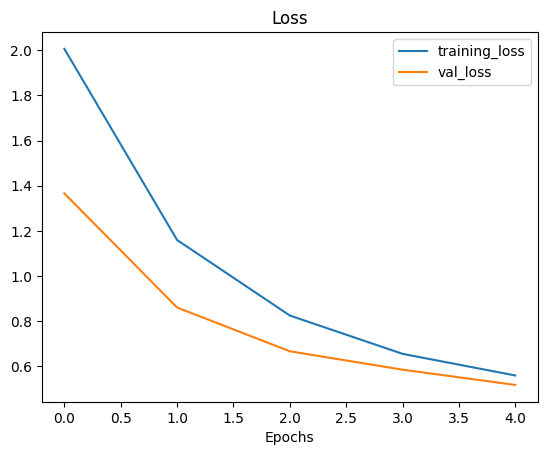

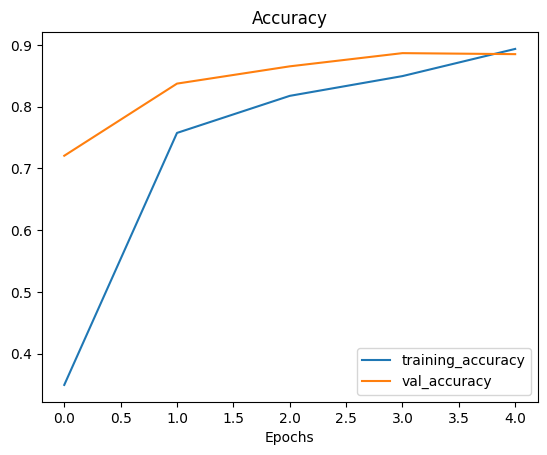

In [13]:

plot_loss_curves(history_10_percent)

In [14]:
input_shape = (1, 4, 4, 3)

tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor: \n {input_tensor} \n")

global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global avg pooled random tensor \n {global_average_pooled_tensor}")
print(f"Shape of global avg: {global_average_pooled_tensor.shape}")

Random input tensor: 
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]] 

2D global avg pooled random tensor 
 [[-0.09368646 -0.45840448 -0.2885598 ]]
Shape of global avg: (1, 3)


# Model 1 --> 1 percent

In [15]:

# preprocessed from food 101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data('10_food_classes_1_percent.zip')

--2023-07-06 11:39:12--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 209.85.146.128, 209.85.147.128, 142.250.125.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|209.85.146.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M   178MB/s    in 0.7s    

2023-07-06 11:39:13 (178 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [16]:
train_dir_1_percent = '10_food_classes_1_percent/train'
test_dir_1_percent = '10_food_classes_1_percent/test'

In [17]:
walk_through_dir('10_food_classes_1_percent/')

There are 2 directories and 0 images in '10_food_classes_1_percent/'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There 

In [18]:
# Setup data loaders

train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           image_size=IMG_SIZE,
                                                                           batch_size=32,
                                                                           label_mode='categorical')

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir_1_percent,
                                                                image_size=IMG_SIZE,
                                                                batch_size=32,
                                                                label_mode='categorical')

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [19]:
# Adding data augmentation into the model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create data augmentation stage with horizontal flipping, rotaion, zooms, etc
data_aug = keras.Sequential([
    preprocessing.RandomFlip('horizontal'),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    # preprocessing.Rescale(1/255.)  # => It has already rescale data
], name='data_augmentation')

# visualize our data augmentation layer

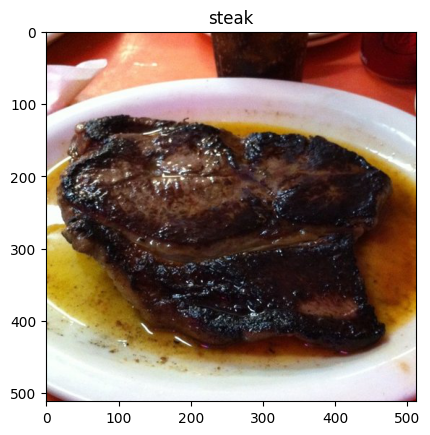

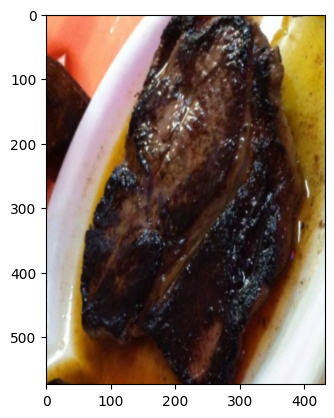

In [20]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

target_class = random.choice(train_data_1_percent.class_names)
target_dir = train_dir_1_percent + "/" + target_class

random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image

# Read the random image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(target_class)
plt.axis = False

# Now lets plot our augmented image
augmented_img = data_aug(img, training=True)
plt.figure()
plt.imshow(augmented_img/255.)

# Model 1: Feature extraction transfer learning on 1% of training data

In [21]:
# Setup input shape and base model
input_shape = (224, 224, 3)

base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create the input layer
inputs = layers.Input(shape=input_shape, name='input_layer')

# Add in data augmentation
x = data_aug(inputs)

# Give base model the inputs without trainging
x = base_model(x, training=False)

# Pooling layer
x = layers.GlobalAveragePooling2D(name='global_avg_pooling_layer')(x)

# Put a dense layer on the output
outputs = layers.Dense(10, activation='softmax', name='output_layer')(x)

# Make a model using the inputs and output
model_1 = keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [22]:
history_1_percent = model_1.fit(train_data_1_percent,
                                epochs=5,
                                steps_per_epoch=len(train_data_1_percent),
                                validation_data=test_data,
                                validation_steps=int(0.25 * len(test_data)),
                                callbacks=[create_tensorboard_callback('tranfer_learning', '1_percent_data')])

Saving TensorBoard log files to: tranfer_learning/1_percent_data/20230706-113919
Epoch 1/5
3/3 [==============================] - 13s 2s/step - loss: 2.3197 - accuracy: 0.1286 - val_loss: 2.2501 - val_accuracy: 0.1579
Epoch 2/5
3/3 [==============================] - 6s 2s/step - loss: 2.1130 - accuracy: 0.2571 - val_loss: 2.1095 - val_accuracy: 0.2582
Epoch 3/5
3/3 [==============================] - 4s 1s/step - loss: 1.8774 - accuracy: 0.4857 - val_loss: 2.0032 - val_accuracy: 0.3092
Epoch 4/5
3/3 [==============================] - 4s 2s/step - loss: 1.6467 - accuracy: 0.6571 - val_loss: 1.8933 - val_accuracy: 0.3849
Epoch 5/5
3/3 [==============================] - 4s 2s/step - loss: 1.5494 - accuracy: 0.6857 - val_loss: 1.8041 - val_accuracy: 0.4556


In [23]:
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 [==============================] - 6s 74ms/step - loss: 1.7923 - accuracy: 0.4436


[1.7922687530517578, 0.44359999895095825]

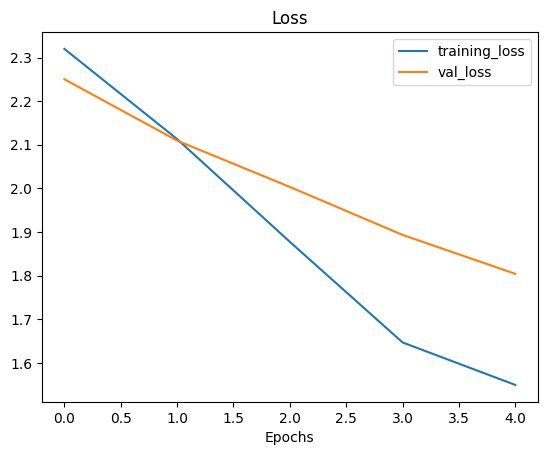

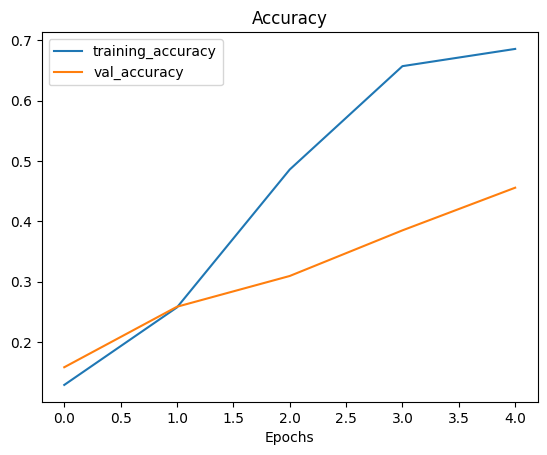

In [24]:
plot_loss_curves(history_1_percent)

# Model 2 : feature extraction transfer learning mmodel with 10%

In [25]:
# !wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# unzip_data('10_food_classes_10_percent.zip')

In [26]:
train_dir_10_percent = '10_food_classes_10_percent/train'
test_dir = '10_food_classes_10_percent/test'

In [27]:
# Set data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode='categorical',
                                                                            image_size=IMG_SIZE)

test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                           label_mode='categorical',
                                                                           image_size=IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [28]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# build data augmentaion layer
data_aug = Sequential([
    preprocessing.RandomFlip('horizontal'),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2)
], name='data_augmentation')

In [29]:
# set up input shape
input_shape = (224, 224, 3)

# create a frozen base model
base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = keras.Input(shape=input_shape, name='input_layer')

# augmenting data
x = data_aug(inputs)

x = base_model(x, training=False)

x = layers.GlobalAveragePooling2D(name='Global_avg_pooling')(x)

outputs = layers.Dense(10, activation='softmax', name='output_layer')(x)

model_2 = keras.Model(inputs, outputs)

model_2.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

# Creating a Model Check points

In [30]:
# set chechpoints path
checkpoint_path = 'ten_percent_model_checkpoints_weights/checkpoint.ckpt'

# creating a model checkpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    save_best_only=False,
    verbose=0,
    save_freq='epoch')


# Fit the model 2 passing in Model Checkpoint callback

In [31]:
# Fit the model saving checkpoints every epoch
initial_epochs = 5
history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                 epochs=initial_epochs,
                                 steps_per_epoch=len(train_data_10_percent),
                                 validation_data=test_data,
                                 validation_steps=int(0.25 * len(test_data)),
                                 callbacks=[create_tensorboard_callback('transfer_learning', '10_percent_data_aug'), checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20230706-114011
Epoch 1/5
24/24 [==============================] - 25s 690ms/step - loss: 2.0025 - accuracy: 0.3427 - val_loss: 1.4654 - val_accuracy: 0.6842
Epoch 2/5
24/24 [==============================] - 13s 538ms/step - loss: 1.3107 - accuracy: 0.6920 - val_loss: 0.9874 - val_accuracy: 0.7829
Epoch 3/5
24/24 [==============================] - 14s 562ms/step - loss: 0.9999 - accuracy: 0.7653 - val_loss: 0.7742 - val_accuracy: 0.8224
Epoch 4/5
24/24 [==============================] - 12s 490ms/step - loss: 0.8462 - accuracy: 0.8000 - val_loss: 0.6934 - val_accuracy: 0.8289
Epoch 5/5
24/24 [==============================] - 12s 480ms/step - loss: 0.7412 - accuracy: 0.8200 - val_loss: 0.6251 - val_accuracy: 0.8372


In [32]:
model_0.evaluate(test_data)

79/79 [==============================] - 13s 141ms/step - loss: 0.5642 - accuracy: 0.8620


[0.5641864538192749, 0.8619999885559082]

In [35]:
results_10_percent_adata_aug = model_2.evaluate(test_data)
results_10_percent_adata_aug

79/79 [==============================] - 7s 77ms/step - loss: 0.6308 - accuracy: 0.8408


[0.6308465600013733, 0.8407999873161316]

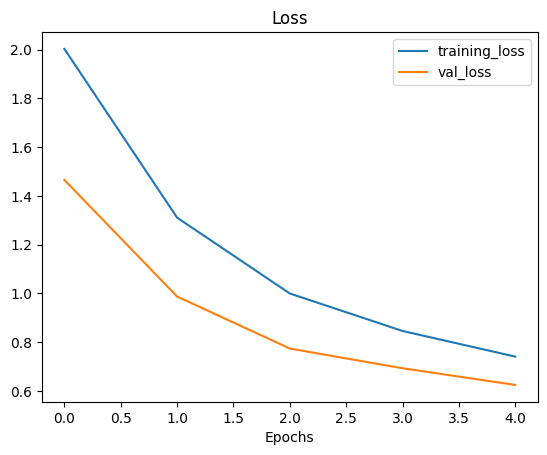

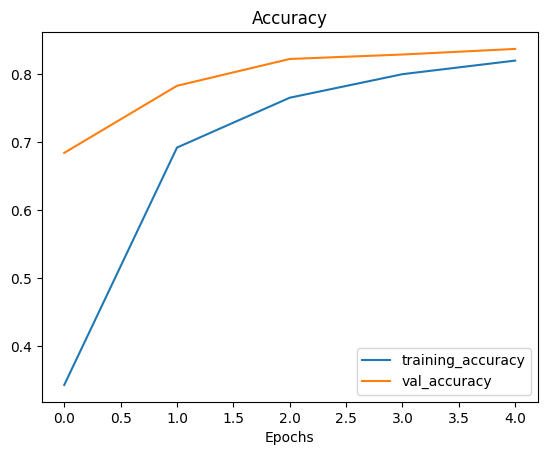

In [36]:
plot_loss_curves(history_10_percent_data_aug)

# Loading in checkpointed weights
-> returns a model to a specific checkpoint

In [37]:
# Load in saved model weight and evaluate model
model_2.load_weights(checkpoint_path)

In [38]:
# Evaluate model_2 with loaded weights
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 7s 74ms/step - loss: 0.6308 - accuracy: 0.8408


In [39]:
import numpy as np

np.isclose(np.array(results_10_percent_adata_aug), np.array(loaded_weights_model_results))

array([ True,  True])

In [40]:
np.array(results_10_percent_adata_aug) - np.array(loaded_weights_model_results)

array([5.96046448e-08, 0.00000000e+00])

## Model 3: Fine tunining on existing 10% data

In [41]:
# Layers in loaded model
model_2.layers

In [42]:
for layer in model_2.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f9e4e685930> True
<keras.engine.sequential.Sequential object at 0x7f9e4e686320> True
<keras.engine.functional.Functional object at 0x7f9e54f59870> False
<keras.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x7f9e4e686050> True
<keras.layers.core.dense.Dense object at 0x7f9e4e35b310> True


In [43]:
# How many trainable variable are in our base model?
print(len(model_2.layers[2].trainable_variables))

0


In [48]:
# To begin fine tuning, lets start by seetting the last 10 layers of our base model trainable
base_model.trainable = True

# Freeze all layers except for the last 10
for layer in base_model.layers[:-10]:
    layer.trainable = False

# Recompile (to recompile the change)
model_2.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])


In [46]:
# check which layes are trainable
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_4 False
2 normalization_2 False
3 rescaling_5 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [49]:
# Now we unfrozen some of the layers closer to the top, how many trainable varibale
print(len(model_2.trainable_variables))

12


In [50]:
# Fine tue for another 5 epochs
fine_tune_epochs = initial_epochs + 5

# Refit the model (same as model_2 except with more trainable layers)
history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                               epochs=fine_tune_epochs,
                                               validation_data=test_data,
                                               validation_steps=int(0.25 * len(test_data)),
                                               initial_epoch=history_10_percent_data_aug.epoch[-1],  # strat traingin from previous last epochs
                                               callbacks=[create_tensorboard_callback('transfer_learning', '10_percent_tune_last_10')])

Saving TensorBoard log files to: transfer_learning/10_percent_tune_last_10/20230706-123019
Epoch 5/10
24/24 [==============================] - 26s 567ms/step - loss: 0.6144 - accuracy: 0.8373 - val_loss: 0.4913 - val_accuracy: 0.8503
Epoch 6/10
24/24 [==============================] - 15s 607ms/step - loss: 0.5048 - accuracy: 0.8533 - val_loss: 0.4486 - val_accuracy: 0.8553
Epoch 7/10
24/24 [==============================] - 11s 448ms/step - loss: 0.4429 - accuracy: 0.8773 - val_loss: 0.4218 - val_accuracy: 0.8586
Epoch 8/10
24/24 [==============================] - 10s 369ms/step - loss: 0.4010 - accuracy: 0.8773 - val_loss: 0.4326 - val_accuracy: 0.8734
Epoch 9/10
24/24 [==============================] - 11s 458ms/step - loss: 0.3683 - accuracy: 0.8920 - val_loss: 0.3839 - val_accuracy: 0.8668
Epoch 10/10
24/24 [==============================] - 11s 432ms/step - loss: 0.3306 - accuracy: 0.9000 - val_loss: 0.4252 - val_accuracy: 0.8651


In [51]:
results_fine_tune_10_percent = model_2.evaluate(test_data)

79/79 [==============================] - 7s 84ms/step - loss: 0.4168 - accuracy: 0.8660


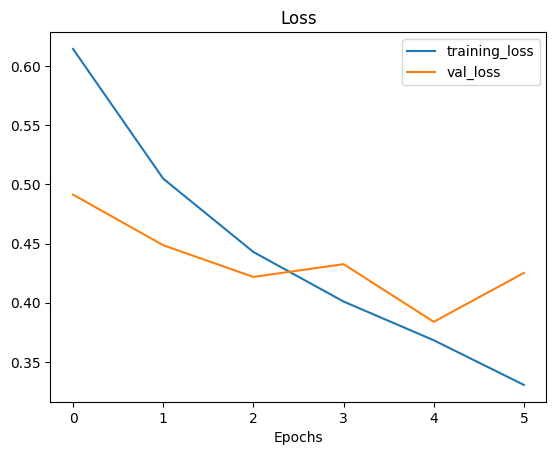

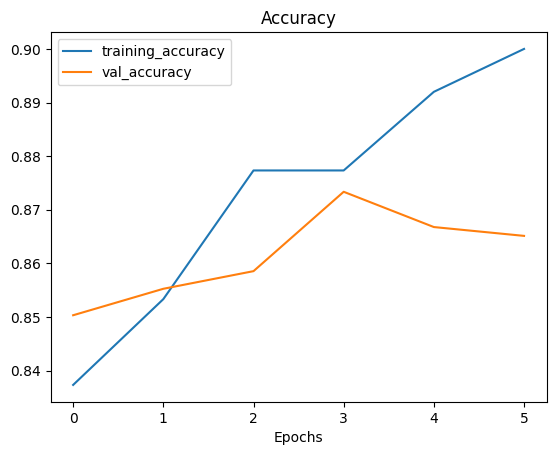

In [52]:
plot_loss_curves(history_fine_10_percent_data_aug)

In [57]:
# Lets create a function to comparing training histories

def compare_historys(original_history, new_history, initial_epochs=5):

    acc = original_history.history['accuracy']
    loss = original_history.history['loss']

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    print(len(total_acc))
    print(total_acc)

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()


11
[0.3426666557788849, 0.6919999718666077, 0.765333354473114, 0.800000011920929, 0.8199999928474426, 0.8373333215713501, 0.8533333539962769, 0.8773333430290222, 0.8773333430290222, 0.8920000195503235, 0.8999999761581421]


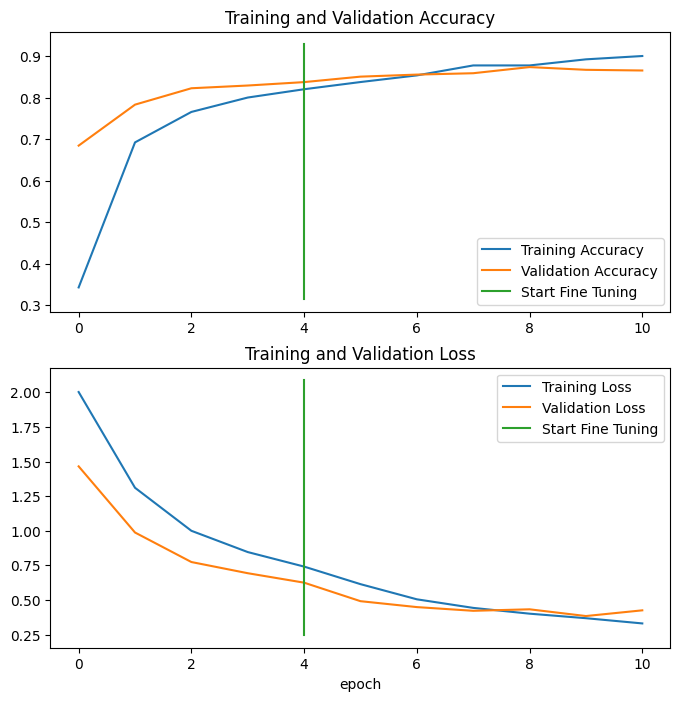

In [58]:
compare_historys(original_history=history_10_percent_data_aug,
                 new_history=history_fine_10_percent_data_aug,
                 initial_epochs=5)

In [60]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
unzip_data('10_food_classes_all_data.zip')


--2023-07-06 12:54:45--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.121.128, 142.250.103.128, 108.177.120.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.121.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip.1’

10_food_classes_all 100%[===================>] 495.13M   140MB/s    in 3.7s    

2023-07-06 12:54:48 (133 MB/s) - ‘10_food_classes_all_data.zip.1’ saved [519183241/519183241]



In [62]:
train_dir_all = '10_food_classes_all_data/train'
test_dir = '10_food_classes_all_data/test'

In [64]:
walk_through_dir('10_food_classes_all_data')

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/train'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/grilled_salmon'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_wings'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/hamburger'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ramen'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/fried_rice'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/sushi'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ice_cream'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/steak'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_curry'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/pizza'.

In [65]:
import tensorflow as tf
IMG_SIZE = (224, 224)

train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir_all,
                                                                     image_size=IMG_SIZE,
                                                                     label_mode='categorical')
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                image_size=IMG_SIZE,
                                                                label_mode='categorical')

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [70]:
# Evalute model 2
model_2.evaluate(test_data)

79/79 [==============================] - 8s 88ms/step - loss: 0.4168 - accuracy: 0.8660


[0.41678744554519653, 0.8659999966621399]

In [72]:
results_fine_tune_10_percent

[0.41678744554519653, 0.8659999966621399]

In [75]:
!pip install -U -q tensorflow==2.9.0
import tensorflow as tf
print(f"TensorFlow version: {tf.__version__}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.7/511.7 MB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 79.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 101.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 45.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 72.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 110.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 43.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-datasets 4.9.2 requires protobuf>=3.20, but you have protobuf 3.19.6 which is incompatible.
tensorflow-metadata 1.13.1 requires protobuf<5,>=3.20.3, but you have protobuf 3.

# Setup for fine tuning on all data
we are converting the model 2 into feature extraction model that is fine tuned

In [77]:
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode="categorical",
                                                                            image_size=IMG_SIZE)
# Note: the test data is the same as the previous experiment, we could
# skip creating this, but we'll leave this here to practice.
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [80]:
# Create a functional model with data augmentation
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers.experimental import preprocessing # OLD

# NEW: Newer versions of TensorFlow (2.10+) can use the tensorflow.keras.layers API directly for data augmentation
data_augmentation = keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  layers.RandomHeight(0.2),
  layers.RandomWidth(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetB0
], name ="data_augmentation")

## OLD
# # Build data augmentation layer
# data_augmentation = Sequential([
#   preprocessing.RandomFlip('horizontal'),
#   preprocessing.RandomHeight(0.2),
#   preprocessing.RandomWidth(0.2),
#   preprocessing.RandomZoom(0.2),
#   preprocessing.RandomRotation(0.2),
#   # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNet
# ], name="data_augmentation")

# Setup the input shape to our model
input_shape = (224, 224, 3)

# Create a frozen base model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input and output layers
inputs = layers.Input(shape=input_shape, name="input_layer") # create input layer
x = data_augmentation(inputs) # augment our training images
x = base_model(x, training=False) # pass augmented images to base model but keep it in inference mode, so batchnorm layers don't get updated: https://keras.io/guides/transfer_learning/#build-a-model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)
model_2 = tf.keras.Model(inputs, outputs)

# Compile
model_2.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), # use Adam optimizer with base learning rate
              metrics=["accuracy"])

In [81]:
# Fit the model saving checkpoints every epoch
initial_epochs = 5
history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                          epochs=initial_epochs,
                                          validation_data=test_data,
                                          validation_steps=int(0.25 * len(test_data)), # do less steps per validation (quicker)
                                          callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_data_aug"),
                                                     checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20230706-132731
Epoch 1/5
24/24 [==============================] - 26s 618ms/step - loss: 1.9453 - accuracy: 0.3493 - val_loss: 1.4756 - val_accuracy: 0.6546
Epoch 2/5
24/24 [==============================] - 12s 423ms/step - loss: 1.2700 - accuracy: 0.7120 - val_loss: 1.0202 - val_accuracy: 0.7697
Epoch 3/5
24/24 [==============================] - 11s 427ms/step - loss: 0.9903 - accuracy: 0.7773 - val_loss: 0.8134 - val_accuracy: 0.7993
Epoch 4/5
24/24 [==============================] - 11s 428ms/step - loss: 0.8275 - accuracy: 0.8000 - val_loss: 0.6966 - val_accuracy: 0.8306
Epoch 5/5
24/24 [==============================] - 9s 336ms/step - loss: 0.7107 - accuracy: 0.8307 - val_loss: 0.6065 - val_accuracy: 0.8454


In [82]:
results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 [==============================] - 7s 82ms/step - loss: 0.6245 - accuracy: 0.8472


[0.6245368719100952, 0.8471999764442444]

In [83]:
import tensorflow as tf
IMG_SIZE = (224, 224)

train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir_all,
                                                                     image_size=IMG_SIZE,
                                                                     label_mode='categorical')
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                image_size=IMG_SIZE,
                                                                label_mode='categorical')

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [85]:
for layer_number, layer in enumerate(model_2.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetb0 False
3 global_average_pooling_layer True
4 output_layer True


In [2]:
import tensorflow as tf
print(tf.__version__)

2.13.0


In [93]:
# updating the model to unfreeze the last 10 layers of efficientnetb0 layer to be trainable
base_model.trainable = True

# Freeze all layers except for the last 10
for layer in base_model.layers[:-10]:
    layer.trainable = False

# Recompile (to recompile the change)
model_2.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])

In [94]:
for layer_number, layer in enumerate(model_2.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetb0 True
3 global_average_pooling_layer True
4 output_layer True


In [95]:
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_6 False
1 rescaling_10 False
2 normalization_5 False
3 rescaling_11 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fa

In [98]:
# Continue to train and fine-tune on 10% of traingin data
fine_tune_epochs = initial_epochs + 5
history_fine_10_classes_full = model_2.fit(train_data_10_classes_full,
                                           epochs=fine_tune_epochs,
                                           validation_data=test_data,
                                           validation_steps=int(0.25 * len(test_data)),
                                           initial_epoch=history_10_percent_data_aug.epoch[-1],
                                           callbacks=[create_tensorboard_callback('transfer_learning', 'full_10_classes_fine_tune_last_10')])

Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tune_last_10/20230706-135846
Epoch 5/10
235/235 [==============================] - 81s 296ms/step - loss: 0.6506 - accuracy: 0.7927 - val_loss: 0.3192 - val_accuracy: 0.8997
Epoch 6/10
235/235 [==============================] - 59s 250ms/step - loss: 0.5234 - accuracy: 0.8321 - val_loss: 0.3191 - val_accuracy: 0.8914
Epoch 7/10
235/235 [==============================] - 54s 226ms/step - loss: 0.4520 - accuracy: 0.8555 - val_loss: 0.2759 - val_accuracy: 0.9095
Epoch 8/10
235/235 [==============================] - 52s 218ms/step - loss: 0.4136 - accuracy: 0.8648 - val_loss: 0.2792 - val_accuracy: 0.9112
Epoch 9/10
235/235 [==============================] - 48s 203ms/step - loss: 0.3746 - accuracy: 0.8784 - val_loss: 0.2936 - val_accuracy: 0.9046
Epoch 10/10
235/235 [==============================] - 46s 195ms/step - loss: 0.3493 - accuracy: 0.8877 - val_loss: 0.2780 - val_accuracy: 0.9128


In [99]:
results_fine_tune_full_data = model_2.evaluate(test_data)
results_fine_tune_full_data

79/79 [==============================] - 7s 75ms/step - loss: 0.2652 - accuracy: 0.9144


[0.26521772146224976, 0.9143999814987183]

11
[0.34933334589004517, 0.7120000123977661, 0.7773333191871643, 0.800000011920929, 0.8306666612625122, 0.7926666736602783, 0.8321333527565002, 0.8554666638374329, 0.864799976348877, 0.8784000277519226, 0.8877333402633667]


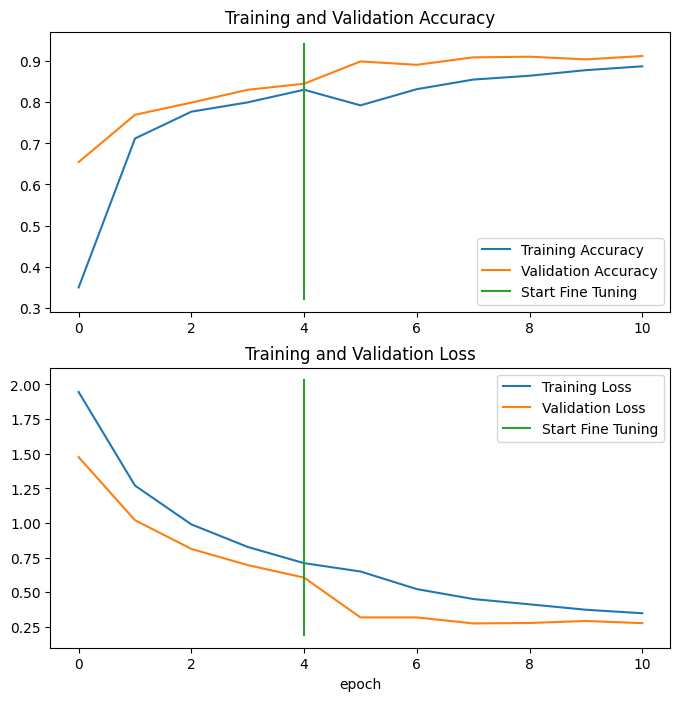

In [100]:
compare_historys(history_10_percent_data_aug, history_fine_10_classes_full, 5)

In [ ]:
!tensorboard dev upload --logdir ./transfer_learning \
  --name "Transfer learning experiments with 10 Food101 Classes" \
  --description "A series of different transfer learning experiments with varying amount of data" \
  --one_shot

In [108]:
final_model = model_2.fit(train_data_10_classes_full,
                          epochs=10,
                          validation_data=test_data,
                          validation_steps=len(test_data),
                          # initial_epoch=final_model.epoch[-1]
                          )

Epoch 1/10
235/235 [==============================] - 48s 202ms/step - loss: 0.2777 - accuracy: 0.9108 - val_loss: 0.2736 - val_accuracy: 0.9108
Epoch 2/10
235/235 [==============================] - 47s 199ms/step - loss: 0.2625 - accuracy: 0.9149 - val_loss: 0.2532 - val_accuracy: 0.9164
Epoch 3/10
235/235 [==============================] - 43s 178ms/step - loss: 0.2418 - accuracy: 0.9251 - val_loss: 0.2766 - val_accuracy: 0.9112
Epoch 4/10
235/235 [==============================] - 44s 187ms/step - loss: 0.2258 - accuracy: 0.9299 - val_loss: 0.2554 - val_accuracy: 0.9156
Epoch 5/10
235/235 [==============================] - 44s 186ms/step - loss: 0.2087 - accuracy: 0.9337 - val_loss: 0.2477 - val_accuracy: 0.9216
Epoch 6/10
235/235 [==============================] - 42s 175ms/step - loss: 0.1990 - accuracy: 0.9408 - val_loss: 0.2648 - val_accuracy: 0.9176
Epoch 7/10
235/235 [==============================] - 44s 184ms/step - loss: 0.1855 - accuracy: 0.9433 - val_loss: 0.2515 - val_ac

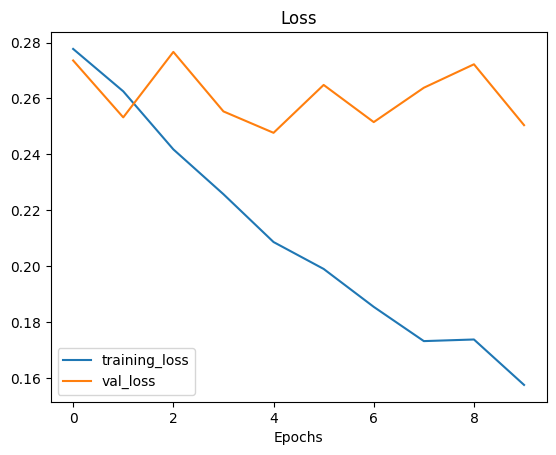

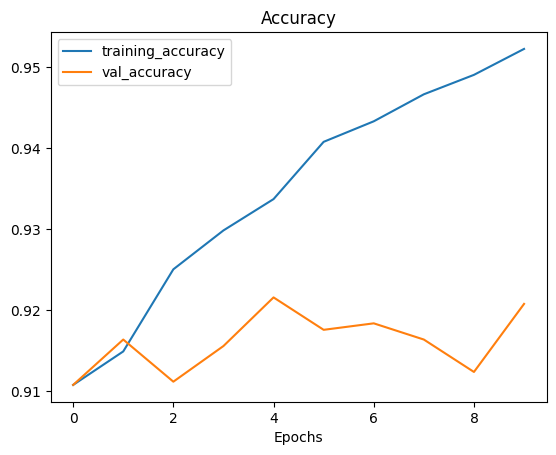

In [112]:
plot_loss_curves(final_model)

In [118]:
import shutil
shutil.make_archive('EfficientB0-transferLearning-Model1', 'zip', 'EfficientB0-transferLearning-Model1')

'/content/EfficientB0-transferLearning-Model1.zip'